In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os

Extracting mnist/data/train-images-idx3-ubyte.gz
Extracting mnist/data/train-labels-idx1-ubyte.gz
Extracting mnist/data/t10k-images-idx3-ubyte.gz
Extracting mnist/data/t10k-labels-idx1-ubyte.gz


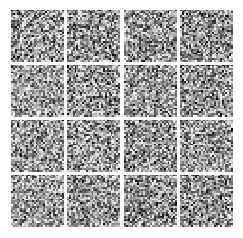

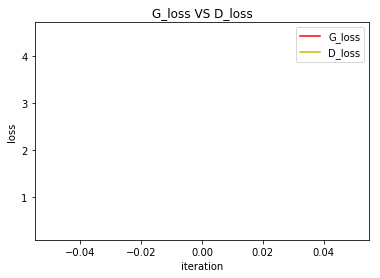

Iter: 0
D loss: 0.3004
G_loss: 4.506



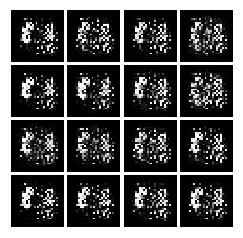

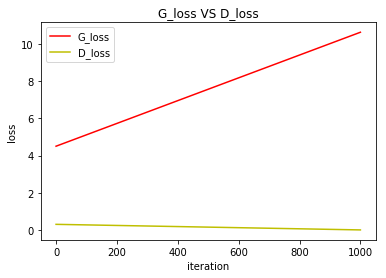

Iter: 1000
D loss: 0.0001182
G_loss: 10.64



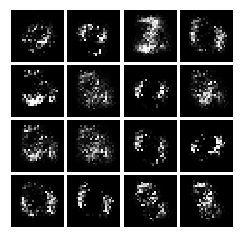

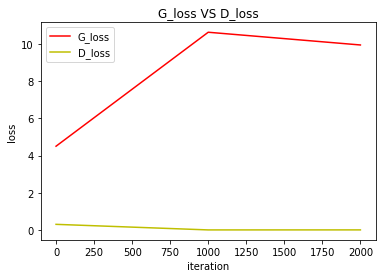

Iter: 2000
D loss: 0.001543
G_loss: 9.955



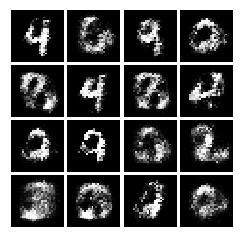

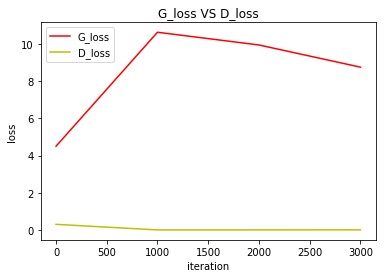

Iter: 3000
D loss: 0.002675
G_loss: 8.762



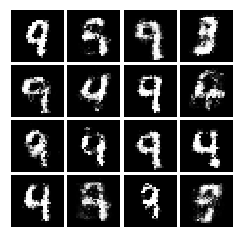

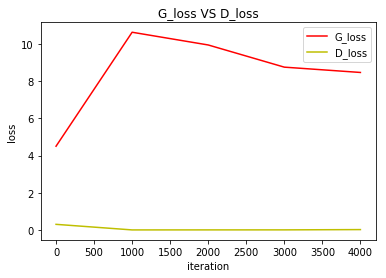

Iter: 4000
D loss: 0.01764
G_loss: 8.476



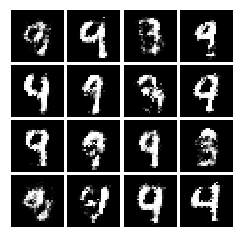

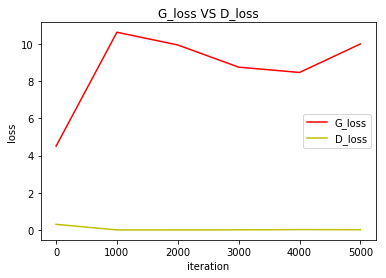

Iter: 5000
D loss: 0.01134
G_loss: 10.01



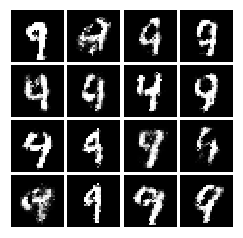

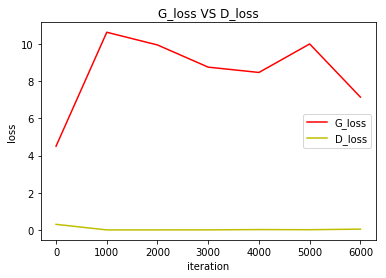

Iter: 6000
D loss: 0.0422
G_loss: 7.149



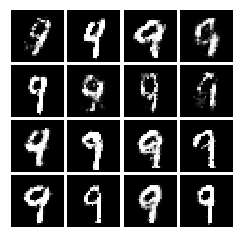

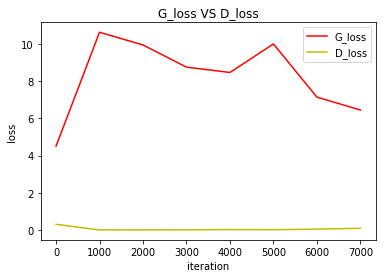

Iter: 7000
D loss: 0.08747
G_loss: 6.453



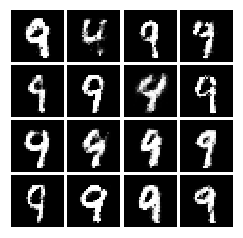

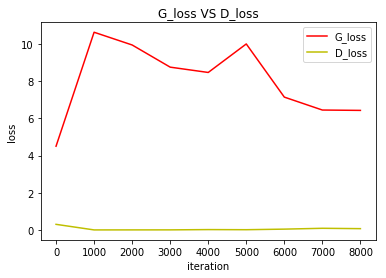

Iter: 8000
D loss: 0.06831
G_loss: 6.434



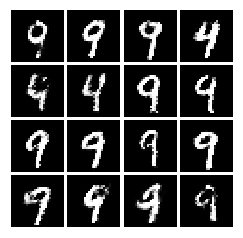

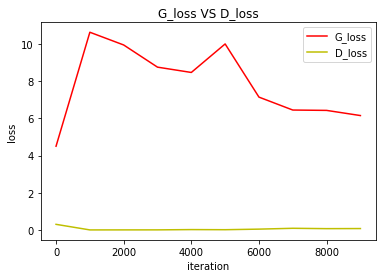

Iter: 9000
D loss: 0.07356
G_loss: 6.156



In [10]:
def xavier_init(size):
    in_dim = size[0]
    xavier_stddev = 1. / tf.sqrt(in_dim / 2.)
    
    return tf.random_normal(shape=size, stddev=xavier_stddev)


X = tf.placeholder(tf.float32, shape=[None, 784])

D_W1 = tf.Variable(xavier_init([784, 128]))
D_b1 = tf.Variable(tf.zeros(shape=[128]))

D_W2 = tf.Variable(xavier_init([128, 1]))
D_b2 = tf.Variable(tf.zeros(shape=[1]))

theta_D = [D_W1, D_W2, D_b1, D_b2]


Z = tf.placeholder(tf.float32, shape=[None, 100])

G_W1 = tf.Variable(xavier_init([100, 128]))
G_b1 = tf.Variable(tf.zeros(shape=[128]))

G_W2 = tf.Variable(xavier_init([128, 784]))
G_b2 = tf.Variable(tf.zeros(shape=[784]))

theta_G = [G_W1, G_W2, G_b1, G_b2]


def sample_Z(m, n):
    return np.random.uniform(-1., 1., size=[m, n])


def generator(z):
    G_h1 = tf.nn.relu(tf.matmul(z, G_W1) + G_b1)
    G_log_prob = tf.matmul(G_h1, G_W2) + G_b2
    G_prob = tf.nn.sigmoid(G_log_prob)

    return G_prob


def discriminator(x):
    D_h1 = tf.nn.relu(tf.matmul(x, D_W1) + D_b1)
    D_logit = tf.matmul(D_h1, D_W2) + D_b2
    D_prob = tf.nn.sigmoid(D_logit)

    return D_prob, D_logit


def plot_sample(samples):
    fig = plt.figure(figsize=(4, 4))
    gs = gridspec.GridSpec(4, 4)
    gs.update(wspace=0.05, hspace=0.05)

    for i, sample in enumerate(samples):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(sample.reshape(28, 28), cmap='Greys_r')

    return fig

def plot_loss(G_iteration_list,G_loss_list,D_iteration_list,D_loss_list):
    fig = plt.figure()
    plt.plot(G_iteration_list, G_loss_list, 'r')  
    plt.plot(D_iteration_list, D_loss_list, 'y')
    plt.xlabel('iteration')
    plt.ylabel('loss')
    plt.legend(['G_loss','D_loss'])
    plt.title("G_loss VS D_loss")
    return fig


G_sample = generator(Z)
D_real, D_logit_real = discriminator(X)
D_fake, D_logit_fake = discriminator(G_sample)

# D_loss = -tf.reduce_mean(tf.log(D_real) + tf.log(1. - D_fake))
# G_loss = -tf.reduce_mean(tf.log(D_fake))

# Alternative losses:
# -------------------
D_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_logit_real, labels=tf.ones_like(D_logit_real)))
D_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_logit_fake, labels=tf.zeros_like(D_logit_fake)))
D_loss = D_loss_real + D_loss_fake
G_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_logit_fake, labels=tf.ones_like(D_logit_fake)))

D_solver = tf.train.AdamOptimizer().minimize(D_loss, var_list=theta_D)
G_solver = tf.train.AdamOptimizer().minimize(G_loss, var_list=theta_G)

mb_size = 100
Z_dim = 100

mnist = tf.contrib.learn.datasets.mnist.read_data_sets(train_dir='mnist/data', one_hot=True)

if not os.path.exists('out_new/'):
    os.makedirs('out_new/')

i = 0
threshold = 0.9
is_first_train_D = True
K=5
R=1
G_iteration_list=[]
G_loss_list=[]
D_iteration_list=[]
D_loss_list=[]
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for it in range(10000):
        if it % 1000 == 0:
            samples = sess.run(G_sample, feed_dict={Z: sample_Z(16, Z_dim)})

            fig = plot_sample(samples)
            plt.savefig('out_new/{}.png'.format(str(i).zfill(3)), bbox_inches='tight')
            i += 1
            plt.show()
            plt.close(fig)

        X_mb, _ = mnist.train.next_batch(mb_size)

        for index_d in range(K):
            input_sample_z = np.empty([0,100],np.float32)
            is_full = False
            while not is_full:
                sample_z = sample_Z(mb_size, Z_dim)
                D_prob = sess.run([D_fake], feed_dict={Z: sample_z})
                idx,_ = np.where(D_prob[0] < threshold)
                if len(idx) <mb_size:
                    curr_sample_size = input_sample_z.shape[0]
                    input_sample_z = np.vstack((input_sample_z, sample_z[idx[0:mb_size-curr_sample_size]]))                        
                    if input_sample_z.shape[0] == mb_size:
                        is_full = True
                        break
                else:
                    is_full = True
                    input_sample_z = np.vstack((input_sample_z, sample_z[idx]))
            _, D_loss_curr = sess.run([D_solver, D_loss], feed_dict={X: X_mb, Z: input_sample_z})

        for index_g in range(R):
            _, G_loss_curr = sess.run([G_solver, G_loss], feed_dict={Z: sample_Z(mb_size, Z_dim)})

        if it % 1000 == 0:
            G_iteration_list.append(it)
            D_iteration_list.append(it)
            G_loss_list.append(G_loss_curr)
            D_loss_list.append(D_loss_curr)
            fig = plot_loss(G_iteration_list,G_loss_list,D_iteration_list,D_loss_list)
            plt.show()
            plt.close(fig)
            print('Iter: {}'.format(it))
            print('D loss: {:.4}'.format(D_loss_curr))
            print('G_loss: {:.4}'.format(G_loss_curr))
            print()


# Original

Extracting mnist/data/train-images-idx3-ubyte.gz
Extracting mnist/data/train-labels-idx1-ubyte.gz
Extracting mnist/data/t10k-images-idx3-ubyte.gz
Extracting mnist/data/t10k-labels-idx1-ubyte.gz


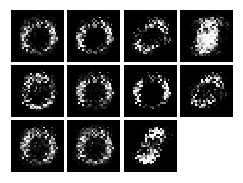

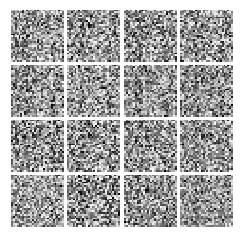

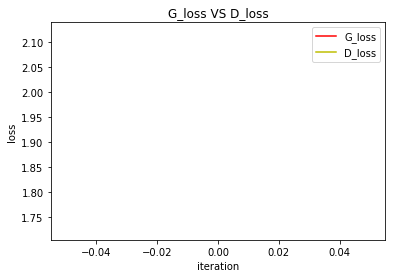

Iter: 0
D loss: 1.724
G_loss: 2.119



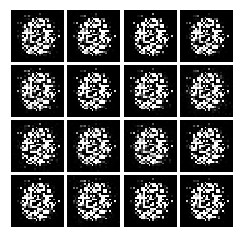

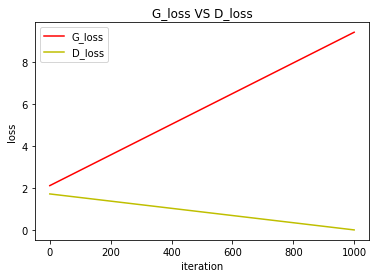

Iter: 1000
D loss: 0.009295
G_loss: 9.427



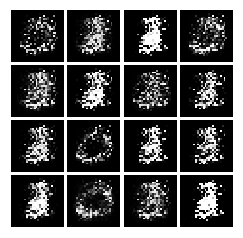

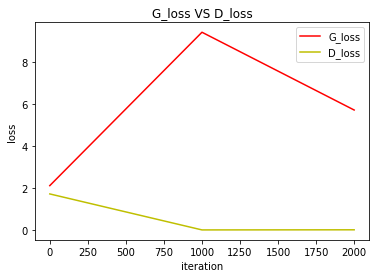

Iter: 2000
D loss: 0.01483
G_loss: 5.722



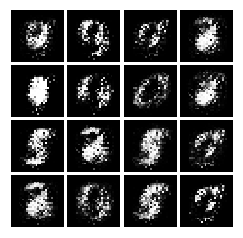

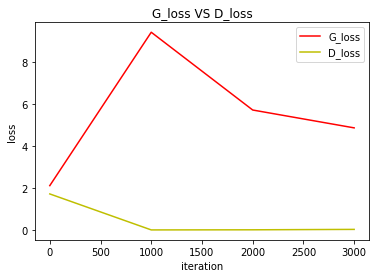

Iter: 3000
D loss: 0.03439
G_loss: 4.871



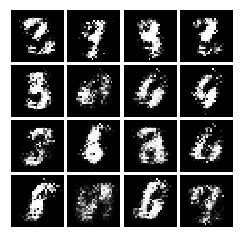

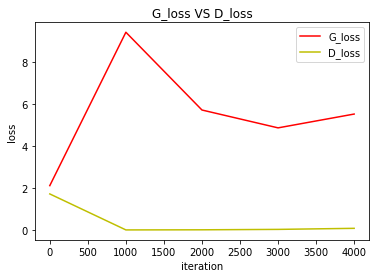

Iter: 4000
D loss: 0.08485
G_loss: 5.53



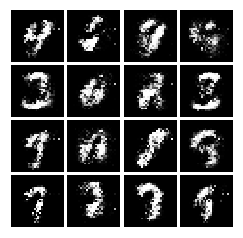

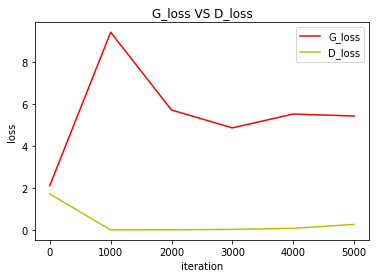

Iter: 5000
D loss: 0.2716
G_loss: 5.436



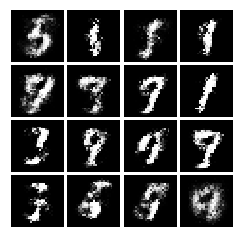

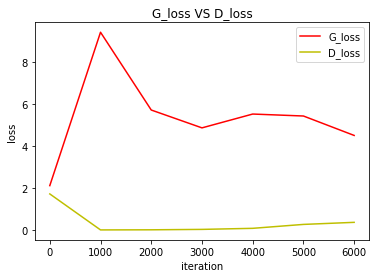

Iter: 6000
D loss: 0.3702
G_loss: 4.51



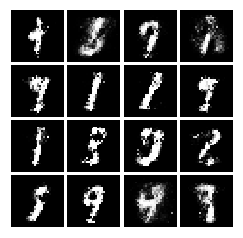

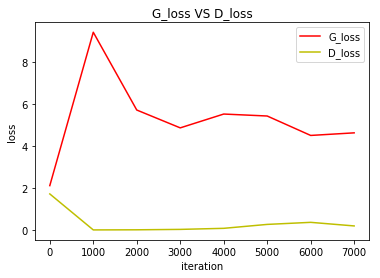

Iter: 7000
D loss: 0.1991
G_loss: 4.634



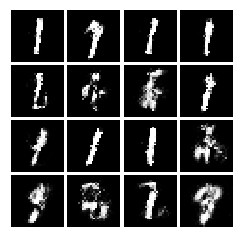

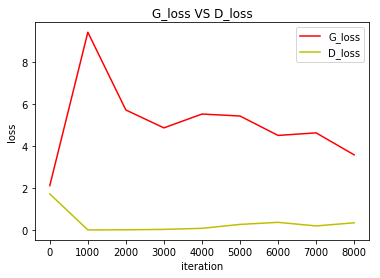

Iter: 8000
D loss: 0.3482
G_loss: 3.585



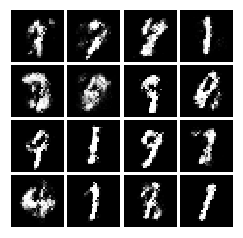

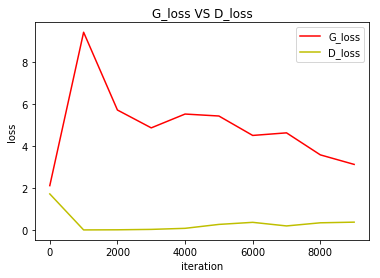

Iter: 9000
D loss: 0.3793
G_loss: 3.13



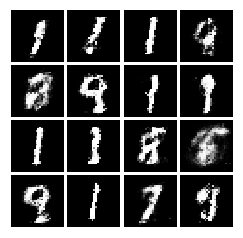

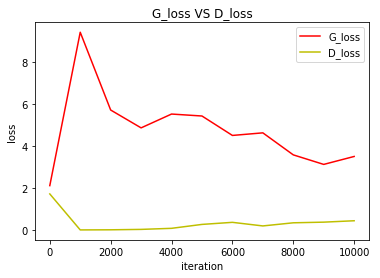

Iter: 10000
D loss: 0.4459
G_loss: 3.509



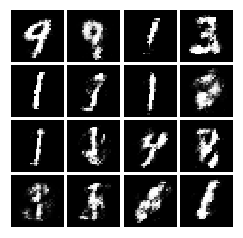

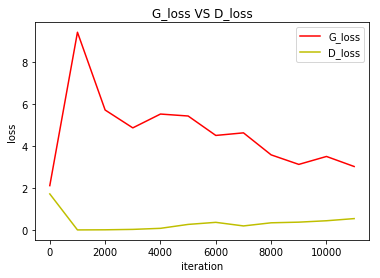

Iter: 11000
D loss: 0.5483
G_loss: 3.03



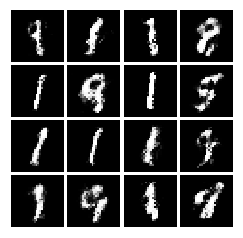

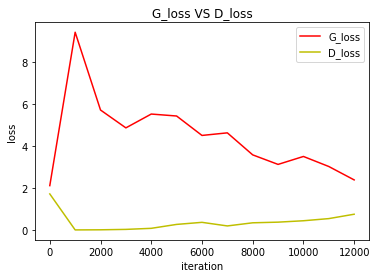

Iter: 12000
D loss: 0.7571
G_loss: 2.392



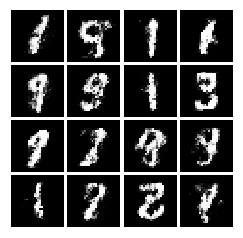

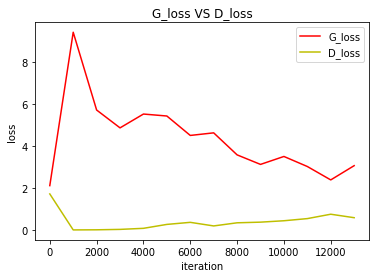

Iter: 13000
D loss: 0.5915
G_loss: 3.07



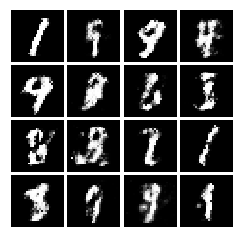

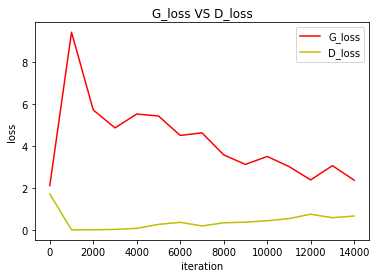

Iter: 14000
D loss: 0.6717
G_loss: 2.378



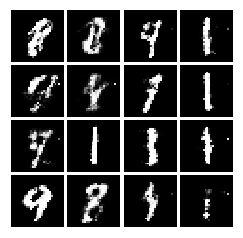

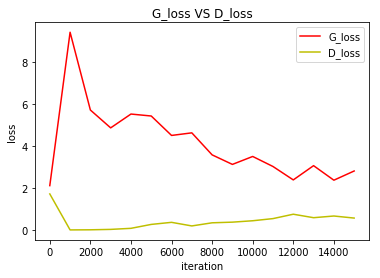

Iter: 15000
D loss: 0.5737
G_loss: 2.817



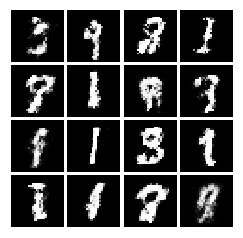

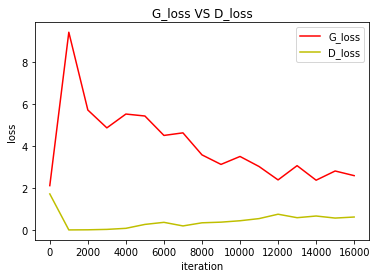

Iter: 16000
D loss: 0.6235
G_loss: 2.595



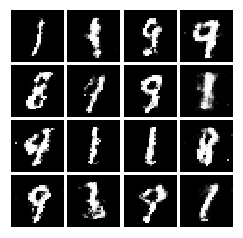

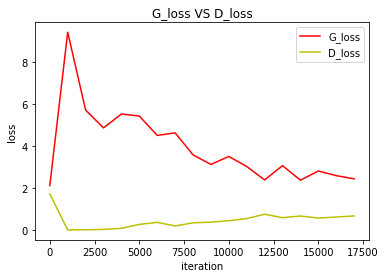

Iter: 17000
D loss: 0.6748
G_loss: 2.441



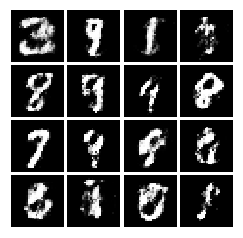

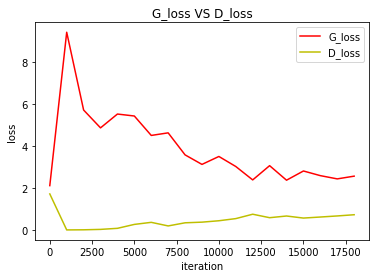

Iter: 18000
D loss: 0.7327
G_loss: 2.571



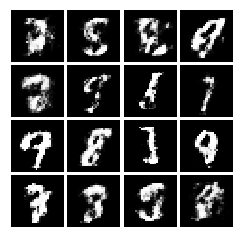

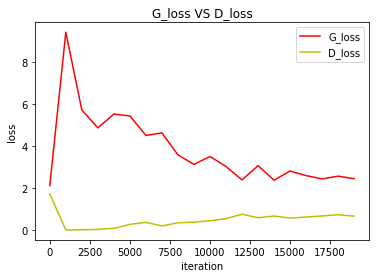

Iter: 19000
D loss: 0.666
G_loss: 2.45



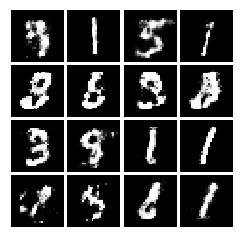

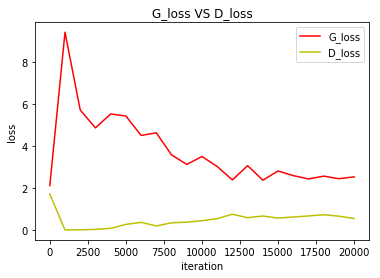

Iter: 20000
D loss: 0.5502
G_loss: 2.538



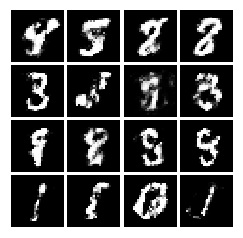

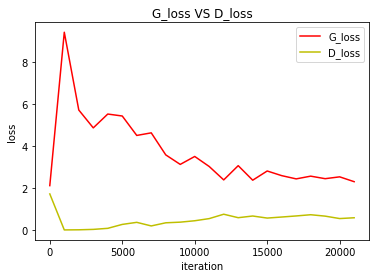

Iter: 21000
D loss: 0.5884
G_loss: 2.307



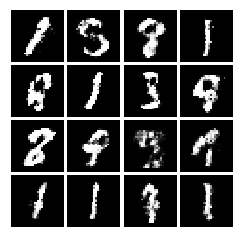

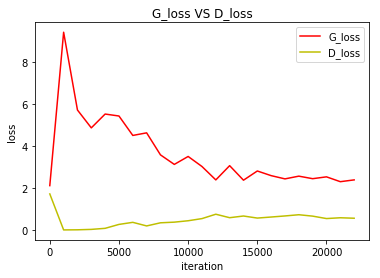

Iter: 22000
D loss: 0.566
G_loss: 2.393



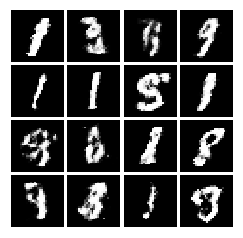

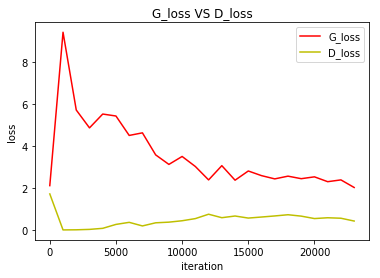

Iter: 23000
D loss: 0.432
G_loss: 2.031



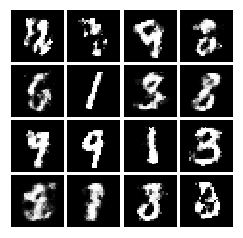

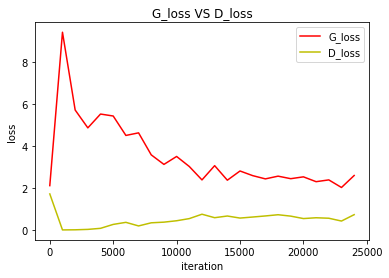

Iter: 24000
D loss: 0.736
G_loss: 2.602



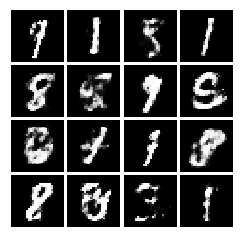

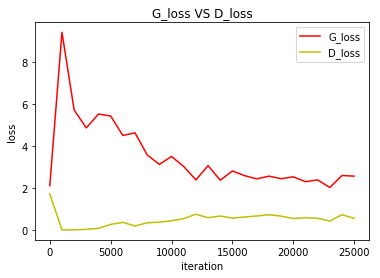

Iter: 25000
D loss: 0.5596
G_loss: 2.571



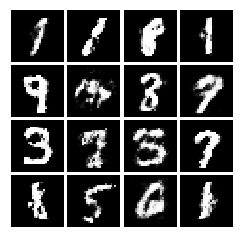

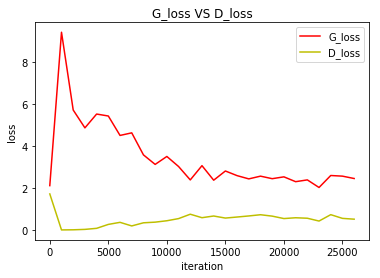

Iter: 26000
D loss: 0.5208
G_loss: 2.458



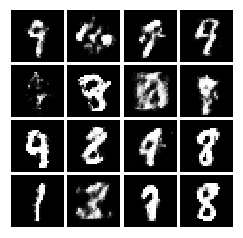

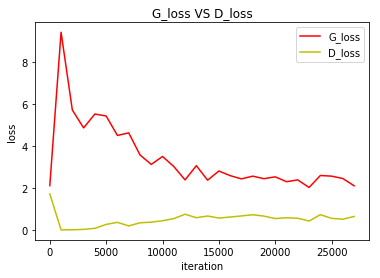

Iter: 27000
D loss: 0.6501
G_loss: 2.11



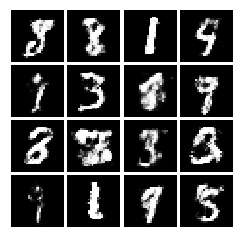

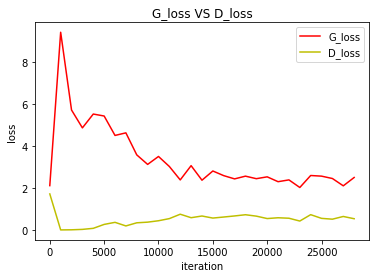

Iter: 28000
D loss: 0.5425
G_loss: 2.508



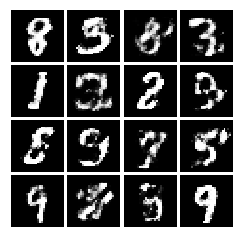

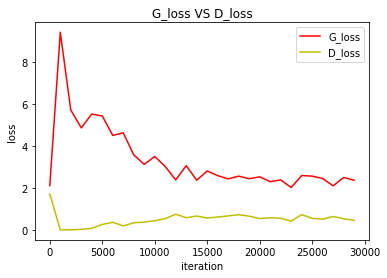

Iter: 29000
D loss: 0.4609
G_loss: 2.376



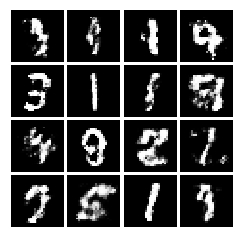

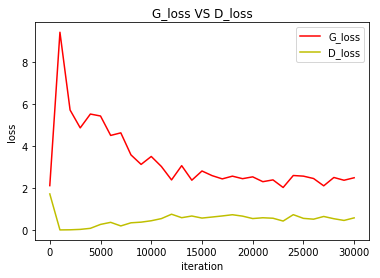

Iter: 30000
D loss: 0.5835
G_loss: 2.494



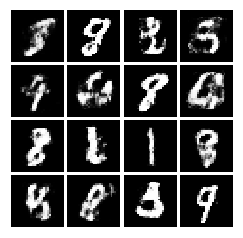

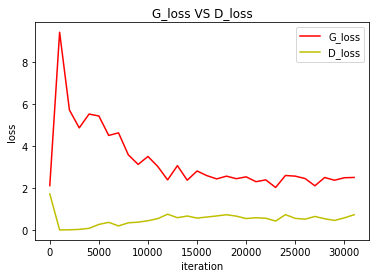

Iter: 31000
D loss: 0.7322
G_loss: 2.509



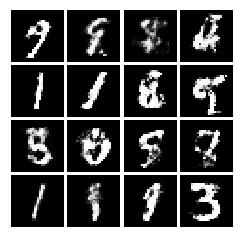

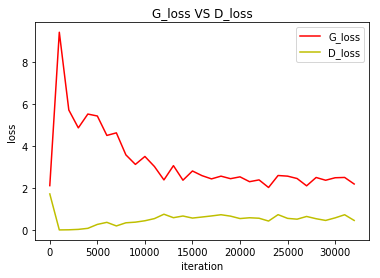

Iter: 32000
D loss: 0.4607
G_loss: 2.197



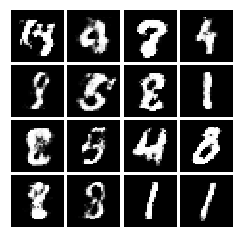

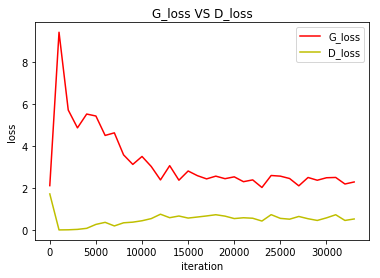

Iter: 33000
D loss: 0.5305
G_loss: 2.294



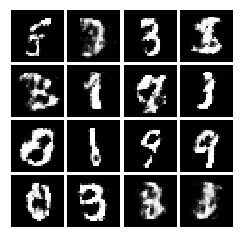

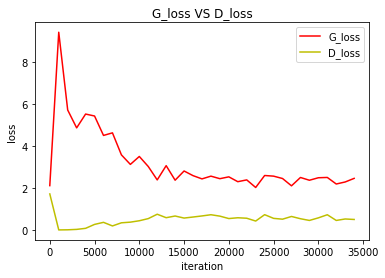

Iter: 34000
D loss: 0.5072
G_loss: 2.465



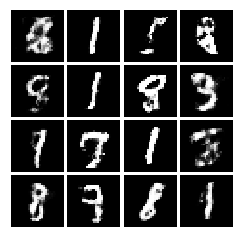

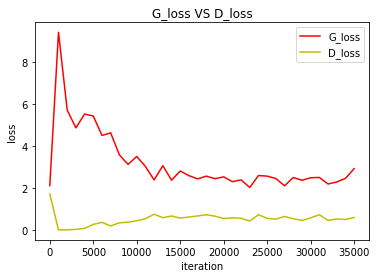

Iter: 35000
D loss: 0.602
G_loss: 2.929



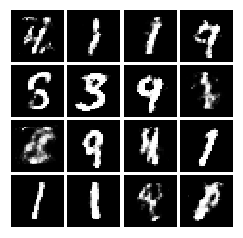

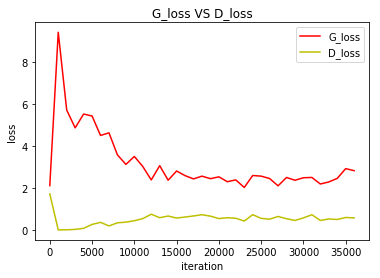

Iter: 36000
D loss: 0.5808
G_loss: 2.832



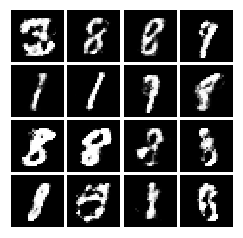

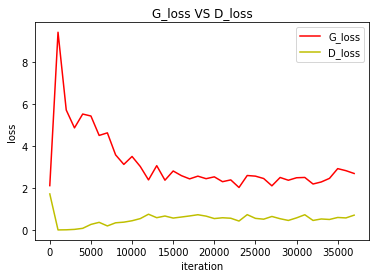

Iter: 37000
D loss: 0.7123
G_loss: 2.697



KeyboardInterrupt: 

In [6]:
def xavier_init(size):
    in_dim = size[0]
    xavier_stddev = 1. / tf.sqrt(in_dim / 2.)
    return tf.random_normal(shape=size, stddev=xavier_stddev)


X = tf.placeholder(tf.float32, shape=[None, 784])

D_W1 = tf.Variable(xavier_init([784, 128]))
D_b1 = tf.Variable(tf.zeros(shape=[128]))

D_W2 = tf.Variable(xavier_init([128, 1]))
D_b2 = tf.Variable(tf.zeros(shape=[1]))

theta_D = [D_W1, D_W2, D_b1, D_b2]


Z = tf.placeholder(tf.float32, shape=[None, 100])

G_W1 = tf.Variable(xavier_init([100, 128]))
G_b1 = tf.Variable(tf.zeros(shape=[128]))

G_W2 = tf.Variable(xavier_init([128, 784]))
G_b2 = tf.Variable(tf.zeros(shape=[784]))

theta_G = [G_W1, G_W2, G_b1, G_b2]


def sample_Z(m, n):
    return np.random.uniform(-1., 1., size=[m, n])


def generator(z):
    G_h1 = tf.nn.relu(tf.matmul(z, G_W1) + G_b1)
    G_log_prob = tf.matmul(G_h1, G_W2) + G_b2
    G_prob = tf.nn.sigmoid(G_log_prob)

    return G_prob


def discriminator(x):
    D_h1 = tf.nn.relu(tf.matmul(x, D_W1) + D_b1)
    D_logit = tf.matmul(D_h1, D_W2) + D_b2
    D_prob = tf.nn.sigmoid(D_logit)

    return D_prob, D_logit


def plot_sample(samples):
    fig = plt.figure(figsize=(4, 4))
    gs = gridspec.GridSpec(4, 4)
    gs.update(wspace=0.05, hspace=0.05)

    for i, sample in enumerate(samples):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(sample.reshape(28, 28), cmap='Greys_r')

    return fig

def plot_loss(G_iteration_list,G_loss_list,D_iteration_list,D_loss_list):
    fig = plt.figure()
    plt.plot(G_iteration_list, G_loss_list, 'r')  
    plt.plot(D_iteration_list, D_loss_list, 'y')
    plt.xlabel('iteration')
    plt.ylabel('loss')
    plt.legend(['G_loss','D_loss'])
    plt.title("G_loss VS D_loss")
    return fig
    

G_sample = generator(Z)
D_real, D_logit_real = discriminator(X)
D_fake, D_logit_fake = discriminator(G_sample)

# D_loss = -tf.reduce_mean(tf.log(D_real) + tf.log(1. - D_fake))
# G_loss = -tf.reduce_mean(tf.log(D_fake))

# Alternative losses:
# -------------------
D_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_logit_real, labels=tf.ones_like(D_logit_real)))
D_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_logit_fake, labels=tf.zeros_like(D_logit_fake)))
D_loss = D_loss_real + D_loss_fake
G_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_logit_fake, labels=tf.ones_like(D_logit_fake)))

D_solver = tf.train.AdamOptimizer().minimize(D_loss, var_list=theta_D)
G_solver = tf.train.AdamOptimizer().minimize(G_loss, var_list=theta_G)

mb_size = 128
Z_dim = 100

mnist = tf.contrib.learn.datasets.mnist.read_data_sets(train_dir='mnist/data', one_hot=True)


if not os.path.exists('out/'):
    os.makedirs('out/')

i = 0
G_iteration_list=[]
G_loss_list=[]
D_iteration_list=[]
D_loss_list=[]
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for it in range(100000):
        if it % 1000 == 0:
            samples = sess.run(G_sample, feed_dict={Z: sample_Z(16, Z_dim)})

            fig = plot_sample(samples)
            plt.savefig('out/{}.png'.format(str(i).zfill(3)), bbox_inches='tight')
            i += 1
            plt.show()
            plt.close(fig)

        X_mb, _ = mnist.train.next_batch(mb_size)


        _, D_loss_curr = sess.run([D_solver, D_loss], feed_dict={X: X_mb, Z: sample_Z(mb_size, Z_dim)})
        _, G_loss_curr = sess.run([G_solver, G_loss], feed_dict={Z: sample_Z(mb_size, Z_dim)})

        if it % 1000 == 0:
            G_iteration_list.append(it)
            D_iteration_list.append(it)
            G_loss_list.append(G_loss_curr)
            D_loss_list.append(D_loss_curr)
            fig = plot_loss(G_iteration_list,G_loss_list,D_iteration_list,D_loss_list)
            plt.show()
            plt.close(fig)
            print('Iter: {}'.format(it))
            print('D loss: {:.4}'.format(D_loss_curr))
            print('G_loss: {:.4}'.format(G_loss_curr))
            print()

